# Practice: Dealing with Word Embeddings
##### Credits: embeddings visualization is based on the notebook by [YSDA NLP course](https://github.com/yandexdataschool/nlp_course)

Today we gonna play with word embeddings: train our own little embedding, load one from   gensim model zoo and use it to visualize text corpora.

This whole thing is gonna happen on top of embedding dataset.

__Requirements:__ if you're running locally, in the selected environment run the following command:

```pip install --upgrade nltk gensim bokeh umap-learn```


In [1]:
import os
import sys


if "google.colab" in sys.modules:
    !pip install --upgrade nltk gensim bokeh umap-learn numpy fasttext

In [2]:
import itertools
import string

import numpy as np
import umap
from IPython.display import clear_output
from matplotlib import pyplot as plt
from nltk.tokenize import WordPunctTokenizer

In [3]:
# download the data:
!wget "https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt" -O ./quora.txt -nc
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

File ‘./quora.txt’ already there; not retrieving.


In [4]:
data = list(open("./quora.txt", encoding="utf-8"))
data[50]

"What TV shows or books help you read people's body language?\n"

__Tokenization:__ a typical first step for an nlp task is to split raw data into words.
The text we're working with is in raw format: with all the punctuation and smiles attached to some words, so a simple str.split won't do.

Let's use __`nltk`__ - a library that handles many nlp tasks like tokenization, stemming or part-of-speech tagging.

In [5]:
tokenizer = WordPunctTokenizer()

print(tokenizer.tokenize(data[50]))

['What', 'TV', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', "'", 's', 'body', 'language', '?']


In [6]:
# TASK: lowercase everything and extract tokens with tokenizer.
# data_tok should be a list of lists of tokens for each line in data.

data_tok = [tokenizer.tokenize(x.lower()) for x in data]  # YOUR CODE HEER

Let's peek at the result:

In [7]:
" ".join(data_tok[0])

"can i get back with my ex even though she is pregnant with another guy ' s baby ?"

Small check that everything is alright

In [8]:
assert all(
    isinstance(row, (list, tuple)) for row in data_tok
), "please convert each line into a list of tokens (strings)"
assert all(
    all(isinstance(tok, str) for tok in row) for row in data_tok
), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all("a" <= x.lower() <= "z" for x in tok)
assert all(
    map(lambda l: not is_latin(l) or l.islower(), map(" ".join, data_tok))
), "please make sure to lowercase the data"

__Word vectors:__ as the saying goes, there's more than one way to train word embeddings. There's Word2Vec and GloVe with different objective functions. Then there's fasttext that uses character-level models to train word embeddings. 

The choice is huge, so let's start someplace small: __gensim__ is another NLP library that features many vector-based models incuding word2vec.

In [9]:
from gensim.models import Word2Vec


model = Word2Vec(
    data_tok,
    vector_size=32,  # embedding vector size
    min_count=5,  # consider words that occured at least 5 times
    window=5,
).wv  # define context as a 5-word window around the target word

In [10]:
# now you can get word vectors !
model.get_vector("cat")

array([-1.5431653 ,  0.97715425, -0.5305689 , -0.2627999 ,  0.18205035,
        1.5307562 , -2.3868215 , -2.508867  , -1.8439249 ,  1.7043641 ,
        3.2575023 , -1.3402557 , -0.23343776,  1.0585195 ,  0.48065776,
       -2.4587638 , -4.817348  ,  0.07193051, -2.087004  , -1.6519682 ,
        1.9068419 ,  1.2312367 , -2.0732782 , -1.2508321 ,  0.85045564,
        0.6767869 , -2.4138865 , -1.336415  , -2.3548038 ,  0.35193598,
        1.9157043 , -1.6912142 ], dtype=float32)

In [11]:
# or query similar words directly. Go play with it!
model.most_similar("rat")

[('foam', 0.8750537633895874),
 ('moth', 0.8703183531761169),
 ('blister', 0.8661432266235352),
 ('bleach', 0.8627475500106812),
 ('honey', 0.8542357683181763),
 ('hamster', 0.8480550646781921),
 ('sting', 0.8448188304901123),
 ('stain', 0.8447295427322388),
 ('banana', 0.8441780209541321),
 ('rib', 0.843309223651886)]

## Using pre-trained model

Took it a while, huh? Now imagine training life-sized (100~300D) word embeddings on gigabytes of text: wikipedia articles or twitter posts. 

Thankfully, nowadays you can get a pre-trained word embedding model in 2 lines of code (no sms required, promise).

In [12]:
import gensim.downloader as api


model = api.load("glove-twitter-25")

In [13]:
model.most_similar(positive=["king", "woman"], negative=["man"])

[('meets', 0.8841924071311951),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694),
 ('’s', 0.8174097537994385),
 ('crow', 0.813499391078949),
 ('hunter', 0.8131037950515747),
 ('father', 0.8115834593772888),
 ('soldier', 0.81113600730896),
 ('mercy', 0.8082392811775208),
 ('hero', 0.8082264065742493)]

## Visualizing word vectors

One way to see if our vectors are any good is to plot them. Thing is, those vectors are in 30D+ space and we humans are more used to 2-3D.

Luckily, we machine learners know about __dimensionality reduction__ methods.

Let's use that to plot 1000 most frequent words

In [14]:
model.sort_by_descending_frequency()

In [15]:
words = list(model.key_to_index.keys())[:1000]

print(words[::100])

word_vectors = np.asarray([model[x] for x in words])

['<user>', '_', 'please', 'apa', 'justin', 'text', 'hari', 'playing', 'once', 'sei']


In [16]:
# for each word, compute it's vector with model
word_vectors = np.asarray([model[x] for x in words])  #  YOUR CODE

In [17]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), 25)
assert np.isfinite(word_vectors).all()

In [18]:
word_vectors.shape

(1000, 25)

### Linear projection: PCA

The simplest linear dimensionality reduction method is __P__rincipial __C__omponent __A__nalysis.

In geometric terms, PCA tries to find axes along which most of the variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/pca_fish.png" style="width:30%">


Under the hood, it attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;



In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca = PCA(2)
scaler = StandardScaler()
# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
word_vectors_pca = pca.fit_transform(word_vectors)  # YOUR CODE
word_vectors_pca = scaler.fit_transform(word_vectors_pca)
# and maybe MORE OF YOUR CODE here :)

In [20]:
assert word_vectors_pca.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"
assert max(abs(word_vectors_pca.mean(0))) < 1e-5, "points must be zero-centered"
assert max(abs(1.0 - word_vectors_pca.std(0))) < 1e-2, "points must have unit variance"

### Let's draw it!

In [21]:
import bokeh.models as bm
import bokeh.plotting as pl
from bokeh.io import output_notebook


output_notebook()


def draw_vectors(
    x, y, radius=10, alpha=0.25, color="blue", width=600, height=400, show=True, **kwargs
):
    """draws an interactive plot for data points with auxilirary info on hover"""
    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({"x": x, "y": y, "color": color, **kwargs})

    fig = pl.figure(active_scroll="wheel_zoom", width=width, height=height)
    fig.scatter("x", "y", size=radius, color="color", alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig

Loading BokehJS ...

In [22]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

Figure(id='1004', ...)

### Visualizing neighbors with UMAP
PCA is nice but it's strictly linear and thus only able to capture coarse high-level structure of the data.

If we instead want to focus on keeping neighboring points near, we could use UMAP, which is itself an embedding method. Here you can read __[more on UMAP (ru)](https://habr.com/ru/company/newprolab/blog/350584/)__ and on __[t-SNE](https://distill.pub/2016/misread-tsne/)__, which is also an embedding.

In [23]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(word_vectors)  # преобразовываем

In [24]:
draw_vectors(embedding[:, 0], embedding[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

Figure(id='1113', ...)

## Phrases embeddings

Word embeddings can also be used to represent short phrases. The simplest way is to take __an average__ of vectors for all tokens in the phrase with some weights.

This trick is useful to identify what data are you working with: find if there are any outliers, clusters or other artefacts.

Let's try this new hammer on our data!


### Mean of vectors

In [25]:
def get_phrase_embedding(phrase):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """

    vector = np.zeros([model.vector_size], dtype="float32")
    phrase_tokenized = tokenizer.tokenize(phrase.lower())
    phrase_vectors = [model[x] for x in phrase_tokenized if model.has_index_for(x)]

    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)
    return vector

In [26]:
data[402687]

'What gift should I give to my girlfriend on her birthday?\n'

In [27]:
get_phrase_embedding(data[402687])

array([-0.18204999,  0.30953574,  0.20861094,  0.07982156, -0.22565515,
       -0.33001748,  1.2495784 ,  0.13134292, -0.33788875,  0.06196944,
       -0.231793  ,  0.09389219, -4.9685497 , -0.23611419, -0.32609668,
       -0.092073  ,  0.4407505 , -0.75413746, -0.5389092 , -0.184752  ,
        0.07867809,  0.20018655, -0.16202375,  0.30375698, -0.41255665],
      dtype=float32)

In [28]:
vector = get_phrase_embedding("I'm very sure. This never happened to me before...")

In [29]:
vector

array([ 0.1663555 ,  0.0534049 ,  0.01988658, -0.14495362, -0.48189807,
        0.0201319 ,  1.1701978 ,  0.39422765, -0.5707375 ,  0.07880499,
       -0.34534982, -0.0293695 , -4.785525  ,  0.04907916, -0.08470917,
        0.1303215 ,  0.03921234, -0.18863894, -0.60683554, -0.4688374 ,
        0.12880965,  0.01707016,  0.16700326,  0.4306834 , -0.05759042],
      dtype=float32)

### Visualizing w/ UMAP

In [30]:
# let's only consider ~5k phrases for a first run.
chosen_phrases = data[:: len(data) // 1000]

# compute vectors for chosen phrases and turn them to numpy array
phrase_vectors = np.asarray([get_phrase_embedding(x) for x in chosen_phrases])  # YOUR CODE

In [31]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model.vector_size)

In [32]:
%%time
# map vectors into 2d space with pca, tsne or your other method of choice
# don't forget to normalize

phrase_vectors_2d = umap.UMAP(n_neighbors=3).fit_transform(phrase_vectors)
# phrase_vectors_2d = pca.fit_transform(phrase_vectors)

#phrase_vectors_2d = scaler.fit_transform(phrase_vectors_2d)
#phrase_vectors_2d = (phrase_vectors_2d - phrase_vectors_2d.mean(axis=0)) / phrase_vectors_2d.std(axis=0)

CPU times: user 4.86 s, sys: 251 ms, total: 5.11 s
Wall time: 3.3 s


In [33]:
draw_vectors(
    phrase_vectors_2d[:, 0],
    phrase_vectors_2d[:, 1],
    phrase=[phrase[:50] for phrase in chosen_phrases],
    radius=20,
)

Figure(id='1233', ...)

Finally, let's build a simple "similar question" engine with phrase embeddings we've built.

### Similar question engine

In [34]:
# compute vector embedding for all lines in data
data_vectors = np.vstack([get_phrase_embedding(l) for l in data])

In [35]:
norms = np.linalg.norm(data_vectors, axis=1)

In [36]:
printable_set = set(string.printable)

In [37]:
data_subset = [x for x in data if set(x).issubset(printable_set)]

In [38]:
def find_nearest(query, k=10):
    """
    given text line (query), return k most similar lines from data, sorted from most to least similar
    similarity should be measured as cosine between query and line embedding vectors
    hint: it's okay to use global variables: data and data_vectors. see also: np.argpartition, np.argsort
    """
    query_vector = get_phrase_embedding(query)
    dists = data_vectors.dot(query_vector[:, None])[:, 0] / (
        (norms + 1e-16) * np.linalg.norm(query_vector)
    )
    nearest_elements = dists.argsort(axis=0)[-k:][::-1]
    out = [data[i] for i in nearest_elements]
    return out

In [39]:
results = find_nearest(query="How do I stay active?", k=5)

print("".join(results))

# assert len(results) == 10 and isinstance(results[0], str)
# assert results[0] == 'How do I get to the dark web?\n'
# assert results[3] == 'What can I do to save the world?\n'

How do I stay active?
How do I always stay active?
How do I stay positive?
How do I stay fit?
How do I be friendly?



In [40]:
results = find_nearest(query="How do i enter the matrix?", k=10)

print("".join(results))

assert len(results) == 10 and isinstance(results[0], str)
assert results[0] == "How do I get to the dark web?\n"
# assert results[3] == 'What can I do to save the world?\n'

How do I get to the dark web?
What universal remote do I need and how do I set it up to a Blaupunkt TV?
How do I connect the ASUS_T00Q to my PC?
How do you print the gridlines in Excel 2010?
How do you print the gridlines in Excel 2007?
How do you print the gridlines in Excel 2003?
I would like to create a new website. What do I have to do?
How do I get the new Neko Atsume wallpapers? How do they work?
I want to experience the 4G network. Do I need to change my SIM card from 3G to 4G?
What do I have to do to sell my photography?



In [41]:
find_nearest(query="Why don't i ask a question myself?", k=10)

["Why don't my parents listen to me?\n",
 "Why don't people appreciate me?\n",
 "Why she don't interact with me?\n",
 "Why don't I get a date?\n",
 "Why don't I get a girlfriend?\n",
 "Why don't I have a girlfriend?\n",
 "Why don't I have a boyfriend?\n",
 "Why don't I like people touching me?\n",
 "Why can't I ask a question anonymously?\n",
 "Why don't you use Facebook much?\n"]

### Clustering phrases

In [42]:
from sklearn.cluster import DBSCAN, KMeans

In [43]:
kmeans = KMeans(3)

In [44]:
labels = kmeans.fit_predict(np.asarray(phrase_vectors))

In [45]:
_colors = ["red", "green", "blue"]

In [46]:
draw_vectors(
    phrase_vectors_2d[:, 0],
    phrase_vectors_2d[:, 1],
    color=[_colors[l] for l in labels],
    phrase=[phrase[:50] for phrase in chosen_phrases],
    radius=20,
)

Figure(id='1364', ...)

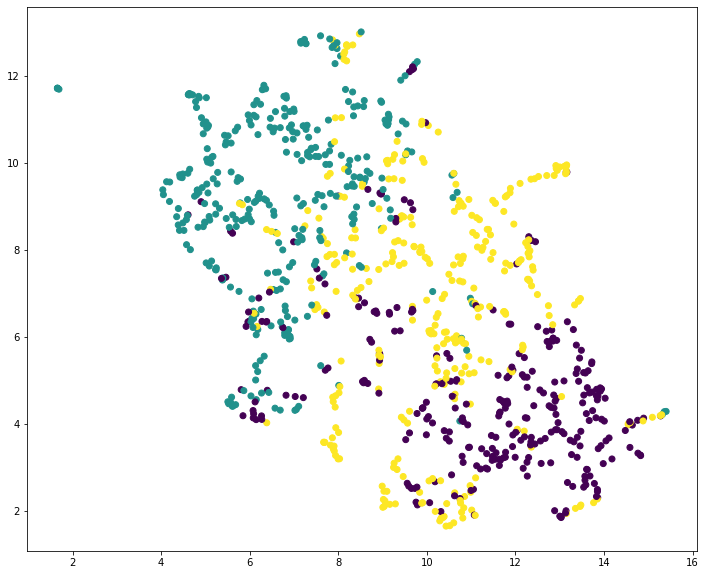

In [47]:
plt.figure(figsize=(12, 10))
plt.scatter(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1], c=labels.astype(float))

__Now what?__
* Try running TSNE instead of UMAP (it takes a long time)
* Try running UMAP or TSNEon all data, not just 1000 phrases
* See what other embeddings are there in the model zoo: `gensim.downloader.info()`
* Take a look at [FastText](https://github.com/facebookresearch/fastText) embeddings
* Optimize find_nearest with locality-sensitive hashing: use [nearpy](https://github.com/pixelogik/NearPy) or `sklearn.neighbors`.

# Continuation

## Visializing neighbors with TSNE

In [48]:
from sklearn.manifold import TSNE

In [49]:
%%time
phrase_vectors_2d = TSNE().fit_transform(phrase_vectors)
# phrase_vectors_2d = pca.fit_transform(phrase_vectors)

# phrase_vectors_2d = scaler.fit_transform(phrase_vectors_2d)
# phrase_vectors_2d = (phrase_vectors_2d - phrase_vectors_2d.mean(axis=0)) / phrase_vectors_2d.std(axis=0)

CPU times: user 15.8 s, sys: 89.6 ms, total: 15.8 s
Wall time: 4.92 s


In [50]:
draw_vectors(
    phrase_vectors_2d[:, 0],
    phrase_vectors_2d[:, 1],
    phrase=[phrase[:50] for phrase in chosen_phrases],
    radius=20,
)

Figure(id='1506', ...)

## UMAP on all data

In [51]:
# let's only consider ~5k phrases for a first run.
chosen_phrases = data[:: len(data) // 10000]
#chosen_phrases = data

# compute vectors for chosen phrases and turn them to numpy array
phrase_vectors = np.asarray([get_phrase_embedding(x) for x in chosen_phrases])  # YOUR CODE

In [52]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model.vector_size)

In [53]:
%%time
# map vectors into 2d space with pca, tsne or your other method of choice
# don't forget to normalize

phrase_vectors_2d = umap.UMAP(n_neighbors=3).fit_transform(phrase_vectors)
# phrase_vectors_2d = pca.fit_transform(phrase_vectors)

phrase_vectors_2d = scaler.fit_transform(phrase_vectors_2d)
#phrase_vectors_2d = (phrase_vectors_2d - phrase_vectors_2d.mean(axis=0)) / phrase_vectors_2d.std(axis=0)

CPU times: user 16.4 s, sys: 784 ms, total: 17.2 s
Wall time: 12.7 s


In [54]:
draw_vectors(
    phrase_vectors_2d[:, 0],
    phrase_vectors_2d[:, 1],
    phrase=[phrase[:50] for phrase in chosen_phrases],
    radius=20,
)

Figure(id='1659', ...)

## Other pretrained embeddings

In [55]:
info = api.info()
print(info.keys())

dict_keys(['corpora', 'models'])


In [56]:
for corpus_name, corpus_data in sorted(info['corpora'].items()):
    print(
        '%s (%d records): %s' % (
            corpus_name,
            corpus_data.get('num_records', -1),
            corpus_data['description'][:40] + '...',
        )
    )

20-newsgroups (18846 records): The notorious collection of approximatel...
__testing_matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Synopsis of t...
__testing_multipart-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Synopsis of t...
fake-news (12999 records): News dataset, contains text and metadata...
patent-2017 (353197 records): Patent Grant Full Text. Contains the ful...
quora-duplicate-questions (404290 records): Over 400,000 lines of potential question...
semeval-2016-2017-task3-subtaskA-unannotated (189941 records): SemEval 2016 / 2017 Task 3 Subtask A una...
semeval-2016-2017-task3-subtaskBC (-1 records): SemEval 2016 / 2017 Task 3 Subtask B and...
text8 (1701 records): First 100,000,000 bytes of plain text fr...
wiki-english-20171001 (4924894 records): Extracted Wikipedia dump from October 20...


In [57]:
for model_name, model_data in sorted(info['models'].items()):
    print(
        '%s (%d records): %s' % (
            model_name,
            model_data.get('num_records', -1),
            model_data['description'][:40] + '...',
        )
    )

__testing_word2vec-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Word vecrors ...
conceptnet-numberbatch-17-06-300 (1917247 records): ConceptNet Numberbatch consists of state...
fasttext-wiki-news-subwords-300 (999999 records): 1 million word vectors trained on Wikipe...
glove-twitter-100 (1193514 records): Pre-trained vectors based on  2B tweets,...
glove-twitter-200 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-25 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-50 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-wiki-gigaword-100 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-200 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-300 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-50 (400000 records): Pre-trained vectors based on Wikipedia 2...
word2vec-google-news-300 (3000000 records): Pre-trai

## FastText

Similar to word2vec but trained on characters ngrams

### gensim

In [58]:
from gensim.models import FastText

In [59]:
model = FastText(
    data_tok,
    vector_size=32,  # embedding vector size
).wv

In [60]:
# now you can get word vectors !
model.get_vector("cat")

array([ 2.1157632 ,  1.1257083 ,  2.9096565 , -2.4821782 ,  0.46916065,
        0.1647193 , -1.8575319 , -2.6001194 , -2.215313  ,  5.330602  ,
        0.81210977,  1.2830137 , -3.7192864 ,  0.10797521,  4.8243175 ,
        0.98506606,  4.2113414 , -2.1301057 , -2.1476886 , -3.0215073 ,
       -4.822352  ,  8.8310795 ,  3.567021  ,  4.1119895 ,  1.2579422 ,
       -0.5861616 , -5.0094256 ,  2.6093638 ,  4.511284  ,  2.5326734 ,
       -0.15659353, -1.1906673 ], dtype=float32)

In [61]:
# or query similar words directly. Go play with it!
model.most_similar("queen")

[('nineteen', 0.890651524066925),
 ('unseen', 0.8872225880622864),
 ('evergreen', 0.8789947032928467),
 ('fifteen', 0.8762969374656677),
 ('spleen', 0.871919572353363),
 ('osteen', 0.8700327277183533),
 ('thirteen', 0.8620149493217468),
 ('manson', 0.8593055009841919),
 ('kitten', 0.8566058874130249),
 ('sheen', 0.8561450839042664)]

### facebook

In [62]:
import fasttext

In [63]:
!wget "https://dl.fbaipublicfiles.com/fasttext/supervised-models/ag_news.bin" -O ./ag_news.bin -nc

File ‘./ag_news.bin’ already there; not retrieving.


In [64]:
wv = fasttext.load_model("ag_news.bin")

In [65]:
wv.get_nearest_neighbors("man")

[(0.9911985993385315, 'jail'),
 (0.9887738823890686, 'ban'),
 (0.988550066947937, 'math'),
 (0.9882484078407288, 'death'),
 (0.9850397109985352, 'moderates'),
 (0.9786755442619324, 'cultural'),
 (0.9762594699859619, 'releases'),
 (0.9738965034484863, 'ntt'),
 (0.9726550579071045, 'bounty'),
 (0.9695026874542236, 'recorders')]

## Locality-sensitive_hashing

In [66]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

In [67]:
data_vectors

array([[-0.20129159,  0.2800847 ,  0.20248146, ...,  0.10165835,
         0.13623685, -0.2027976 ],
       [ 0.19666351,  0.33205202, -0.30904263, ..., -0.19695273,
         0.17203563,  0.03334327],
       [-0.07504975,  0.36995193, -0.05652468, ..., -0.5255473 ,
        -0.5753688 ,  0.00200567],
       ...,
       [ 0.09597785,  0.20665129,  0.07444493, ..., -0.18423735,
         0.0935468 , -0.09371264],
       [-0.13442832,  0.25531003,  0.4493735 , ..., -0.26049483,
         0.18832332, -0.17415   ],
       [ 0.2377116 ,  0.01108817,  0.29171234, ..., -0.32040933,
         0.03558166, -0.29181582]], dtype=float32)

In [68]:
model = api.load("glove-twitter-25")

In [69]:
# Dimension of our vector space
dimension = data_vectors[0].shape[0]

# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 10)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp])

for i, embed in enumerate(data_vectors):
    engine.store_vector(embed, data[i])

In [70]:
def find_nearest(query):
    """
    given text line (query), return k most similar lines from data, sorted from most to least similar
    """
    query_vector = get_phrase_embedding(query)
    out = engine.neighbours(query_vector)
    return out

In [71]:
results = find_nearest(query="How do I stay active?")

for res in results:
    print(res[1], end="")

How do I stay active?
How do I always stay active?
How do I stay positive?
How do I be friendly?
How do you stay organized?
How do I make more friends? How do I?
Why do you organize time?
How do I stay encouraged?
How do I find partner?
How do I be a good texter to girls?


In [72]:
results = find_nearest(query="How do i enter the matrix?")

for res in results:
    print(res[1], end="")

How do I get to the dark web?
What universal remote do I need and how do I set it up to a Blaupunkt TV?
How do I connect the ASUS_T00Q to my PC?
How do you print the gridlines in Excel 2010?
How do you print the gridlines in Excel 2007?
How do you print the gridlines in Excel 2003?
I would like to create a new website. What do I have to do?
How do I get the new Neko Atsume wallpapers? How do they work?
I want to experience the 4G network. Do I need to change my SIM card from 3G to 4G?
What do I have to do to sell my photography?


In [73]:
find_nearest(query="Why don't i ask a question myself?")

[(array([ 0.05628049,  0.03938876, -0.01660313,  0.06431128, -0.08534623,
         -0.00411114,  0.1730377 ,  0.15639954, -0.04367417,  0.00479686,
         -0.10137143, -0.080041  , -0.92920484, -0.0723622 , -0.01433869,
          0.04725331, -0.00261091, -0.06996032, -0.14927593, -0.02577051,
          0.08032319, -0.0080656 ,  0.01606748,  0.06650988, -0.02021982]),
  "Why don't my parents listen to me?\n",
  0.005008740698875358),
 (array([ 0.03510628,  0.03796058, -0.02001454,  0.04621332, -0.07647368,
          0.00315906,  0.13102938,  0.17101246, -0.067031  ,  0.01382817,
         -0.08121556, -0.05658613, -0.93902023, -0.09381503, -0.01085764,
          0.0468155 , -0.01693818, -0.06377686, -0.11500337, -0.00572137,
          0.09595395, -0.00524846,  0.00595099,  0.08493314, -0.03270014]),
  "Why she don't interact with me?\n",
  0.007854441330856998),
 (array([ 0.03812428,  0.05963308, -0.00873453,  0.00607893, -0.06189018,
          0.02591141,  0.13925847,  0.20000056, -0.

# Extra: your own word2vec

In [74]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [75]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [76]:
vocabulary = set(itertools.chain.from_iterable(data_tok))

word_to_index = {word: i for i, word in enumerate(vocabulary)}
index_to_word = {i: word for i, word in enumerate(vocabulary)}
word_counter = {word: 0 for word in word_to_index.keys()}

Generating context pairs:

In [77]:
context_tuple_list = []
w = 4

for text in data_tok:
    for i, word in enumerate(text):
        first_context_word_index = max(0, i - w)
        last_context_word_index = min(i + w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if i != j:
                context_tuple_list.append((word_to_index[word], word_to_index[text[j]]))
                word_counter[word] += 1.0
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 41323344 pairs of target and context words


In [78]:
context_tuple_list[:10]

[(33215, 49447),
 (33215, 51793),
 (33215, 56785),
 (49447, 33215),
 (49447, 51793),
 (49447, 56785),
 (49447, 16341),
 (51793, 33215),
 (51793, 49447),
 (51793, 56785)]

Casting everything to `torch.LongTensor`

In [79]:
data_torch = torch.tensor(context_tuple_list).type(torch.LongTensor)
X_torch = data_torch[:, 0]
y_torch = data_torch[:, 1]
del data_torch

In [80]:
import torch.nn.functional as F

In [81]:
class Word2VecModel(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.fc = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, context_word):
        x = self.embeddings(context_word)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [82]:
model = Word2VecModel(25, len(word_to_index)).to(device)

In [83]:
model

Word2VecModel(
  (embeddings): Embedding(87819, 25)
  (fc): Linear(in_features=25, out_features=87819, bias=True)
)

In [84]:
list(model.parameters())

[Parameter containing:
 tensor([[-1.4910,  0.8544, -1.4428,  ..., -1.3420, -0.7059,  0.8600],
         [ 0.7332, -0.4235,  0.0887,  ...,  0.9346, -1.5068,  1.4939],
         [ 0.8811,  0.1269, -0.0207,  ...,  0.6891, -0.1803, -0.8794],
         ...,
         [ 1.5986, -0.2979, -0.1663,  ..., -0.9495, -2.1783, -0.8551],
         [ 0.5617, -0.1073,  0.7105,  ..., -1.3762,  0.0744,  1.4695],
         [ 1.4973,  1.2583,  0.8643,  ..., -0.8882, -0.7304, -0.2673]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.1100,  0.1909,  0.1764,  ...,  0.0505, -0.0745, -0.0053],
         [ 0.1935, -0.1331,  0.0342,  ..., -0.1535,  0.1387,  0.0643],
         [-0.0236,  0.0167, -0.1180,  ..., -0.1680,  0.1194,  0.1068],
         ...,
         [ 0.1692, -0.0843, -0.1303,  ...,  0.0343, -0.1832,  0.1792],
         [-0.1705, -0.0974, -0.0373,  ..., -0.0529, -0.0184,  0.0829],
         [ 0.0160,  0.0083,  0.0932,  ..., -0.0908,  0.1689,  0.0506]],
        device='cuda:0', r

In [85]:
list(model.embeddings.parameters())

[Parameter containing:
 tensor([[-1.4910,  0.8544, -1.4428,  ..., -1.3420, -0.7059,  0.8600],
         [ 0.7332, -0.4235,  0.0887,  ...,  0.9346, -1.5068,  1.4939],
         [ 0.8811,  0.1269, -0.0207,  ...,  0.6891, -0.1803, -0.8794],
         ...,
         [ 1.5986, -0.2979, -0.1663,  ..., -0.9495, -2.1783, -0.8551],
         [ 0.5617, -0.1073,  0.7105,  ..., -1.3762,  0.0744,  1.4695],
         [ 1.4973,  1.2583,  0.8643,  ..., -0.8882, -0.7304, -0.2673]],
        device='cuda:0', requires_grad=True)]

In [86]:
model(X_torch[:5].to(device)).sum(dim=1)

tensor([-1020231.8750, -1020231.9375, -1020231.8750, -1022709.2500,
        -1022709.2500], device='cuda:0', grad_fn=<SumBackward1>)

In [87]:
#loss_func = nn.CrossEntropyLoss()
loss_func = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
# To reduce learning rate on plateau of the loss functions
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

In [88]:
loss_func(model(X_torch[:5].to(device)), y_torch[:5].to(device))

tensor(12.1248, device='cuda:0', grad_fn=<NllLossBackward>)

In [89]:
batch_size = 1024
#n_iterations = 1000
n_iterations = 401
local_train_loss_history = []

In [90]:
def plot_train_process(train_loss):
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))

    axes.set_title("Loss")
    axes.plot(train_loss, label="train")
    axes.legend()
    plt.show()

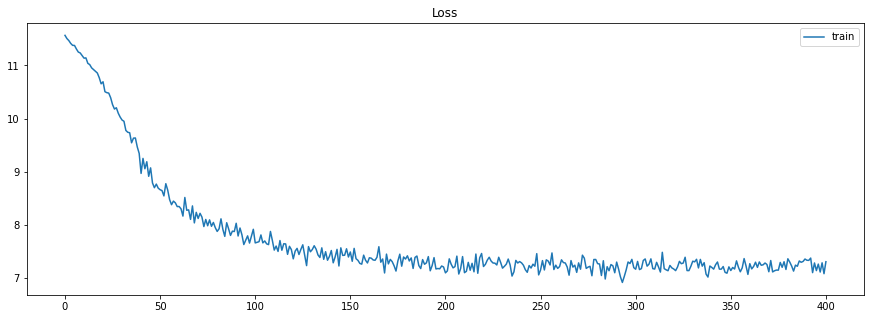

In [91]:
for i in range(n_iterations):

    ix = np.random.randint(0, len(context_tuple_list), batch_size)
    x_batch = X_torch[ix].to(device)
    y_batch = y_torch[ix].to(device)

    # clear gradients
    opt.zero_grad()
    
    # predict log-probabilities or logits
    outputs = model(x_batch)

    # compute loss, just like before
    loss = loss_func(outputs, y_batch)

    # compute gradients
    loss.backward()

    # Adam step
    opt.step()

    local_train_loss_history.append(loss.item())
    lr_scheduler.step(local_train_loss_history[-1])

    if i % 100 == 0:
        clear_output(True)
        plot_train_process(local_train_loss_history)

In [92]:
matrix = next(model.embeddings.parameters()).detach().cpu()

In [93]:
def get_closest(word, top_n):
    global matrix, word_to_index, index_to_word
    y = matrix[word_to_index[word]][None, :]

    dist = F.cosine_similarity(matrix, y)
    index_sorted = torch.argsort(dist)
    top_n = index_sorted[-top_n:]
    return [index_to_word[x] for x in top_n.numpy()]

In [94]:
get_closest("microsoft", 5)

['sulphites', 'tendoniti', 'shuangyashan', 'taash', 'microsoft']

It might look not so promising. Remember about the upgrades to word2vec: subsampling and negative sampling.